
# HandleMissingValues

We know that in this dataset, -1 represents missing values, so there are essentially two ways to deal with missing values:

1. Remove them
2. Impute them


In [ ]:
# import packages

# data processing
import pandas as pd
import numpy as np
from datetime import timedelta, datetime


import re

# data visualization
import plotly.graph_objs as go
from plotly.graph_objs import Bar, Layout
from plotly import offline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# change text color
import colorama
from colorama import Fore, Style

# IPython
from IPython.display import IFrame

In [ ]:
# 读取数据

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
# 全集
fullset = pd.concat([train,test],ignore_index=True)

## Missing value diagnostics



missing value type

- MCAR (Missing completely at Random)
- MAR (Missing at Random) 
- MNAR (Missing not at Random)

MCAR means "there is no relationship between missingness and any value". Therefore, in this case, missing values ​​can be removed. You can do this by removing column missing values; minimizing missing data or removing row missing values.

Missingness has a systematic relationship with other observed data but not with missing data

Finally, MNAR means "there is a relationship between a missingness and its value, missing or not missing".

## Using Metadata to check missing values

In [ ]:
from data_management import meta

In [ ]:
metadata = meta(train,test)

<div class="alert alert-block alert-success"><b>Step 1</b>: Try to find all variables with missing values ​​based on meta and sort them from largest to smallest.    

</div>

In [ ]:
missing_data = metadata[['missing','missing_percent','imputation']][metadata['missing']>0].sort_values(by = 'missing',ascending=False)

In [ ]:
missing_data

missing  missing_percent            imputation
colname                                                      
ps_car_03_cat  1028142  1028142(69.09%)                remove
ps_car_05_cat   666910   666910(44.82%)                remove
ps_reg_03       269456   269456(18.11%)  (mode, median, mean)
ps_car_14       106425    106425(7.15%)  (mode, median, mean)
ps_car_07_cat    28820     28820(1.94%)                  mode
ps_ind_05_cat    14519     14519(0.98%)                  mode
ps_car_09_cat     1446       1446(0.1%)                  mode
ps_ind_02_cat      523       523(0.04%)                  mode
ps_car_01_cat      267       267(0.02%)                  mode
ps_ind_04_cat      228       228(0.02%)                  mode
ps_car_02_cat       10         10(0.0%)                  mode
ps_car_11            6          6(0.0%)        (mode, median)
ps_car_12            1          1(0.0%)  (mode, median, mean)

<div class="alert alert-block alert-success"><b>Step 2</b>: So which variables need to be dropped? Which ones need filling? What method should be used to fill it?
</div>

In [ ]:
cols_to_drop = missing_data[missing_data.imputation == 'remove'].index.to_list()

In [ ]:
cols_to_imp = missing_data.index[2:].to_list()
cols_to_imp_3m = missing_data[missing_data.imputation == ('mode', 'median', 'mean')].index.to_list()
cols_to_imp_2m = missing_data[missing_data.imputation == ('mode', 'median')].index.to_list()
cols_to_imp_1m = missing_data[missing_data.imputation == ('mode')].index.to_list()

### 使用missingno

In [ ]:
import missingno as msno

<AxesSubplot:>

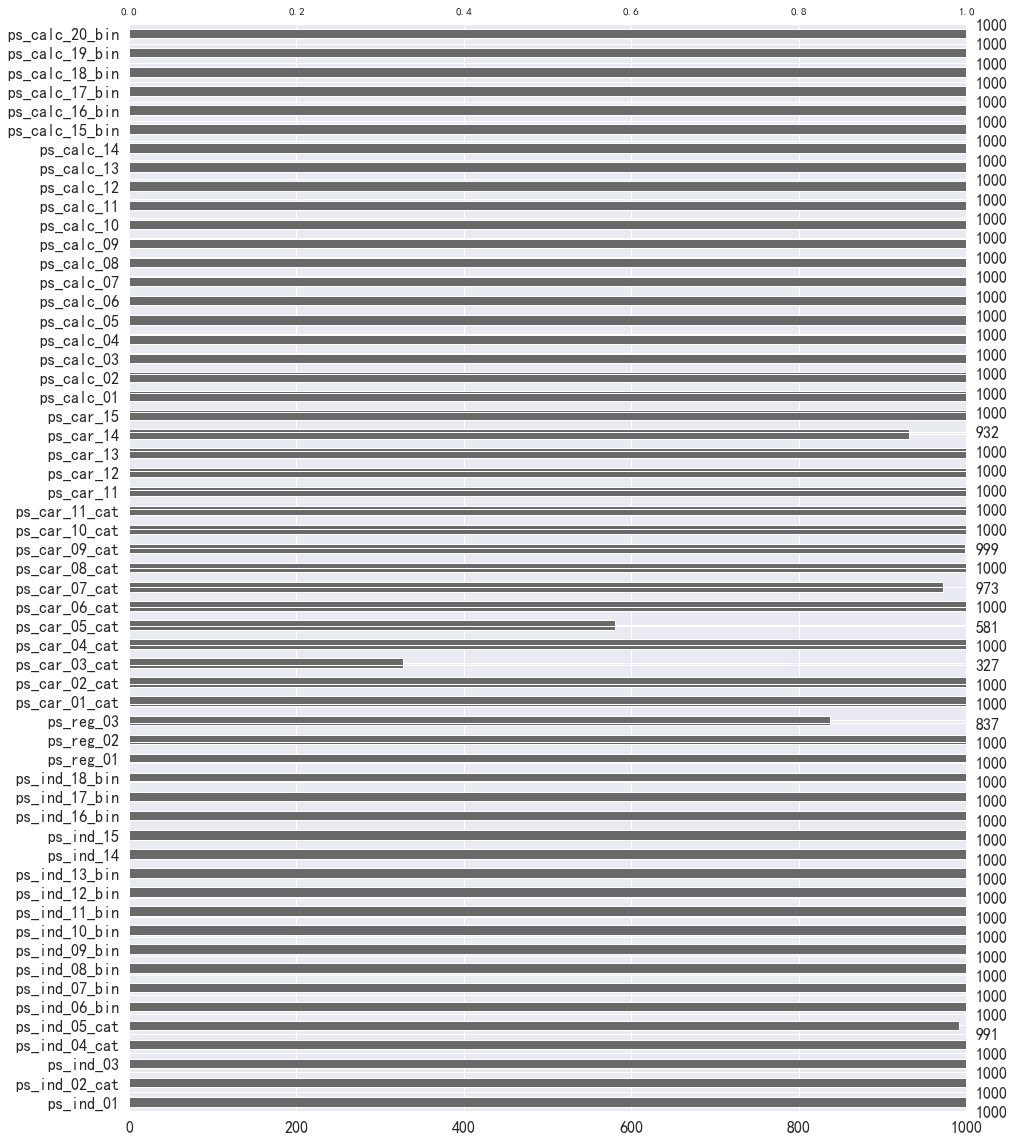

In [ ]:
msno.bar(fullset.drop(['id','target'],axis=1).replace(-1,np.nan).sample(1000),figsize = [15,20]) 

<AxesSubplot:>

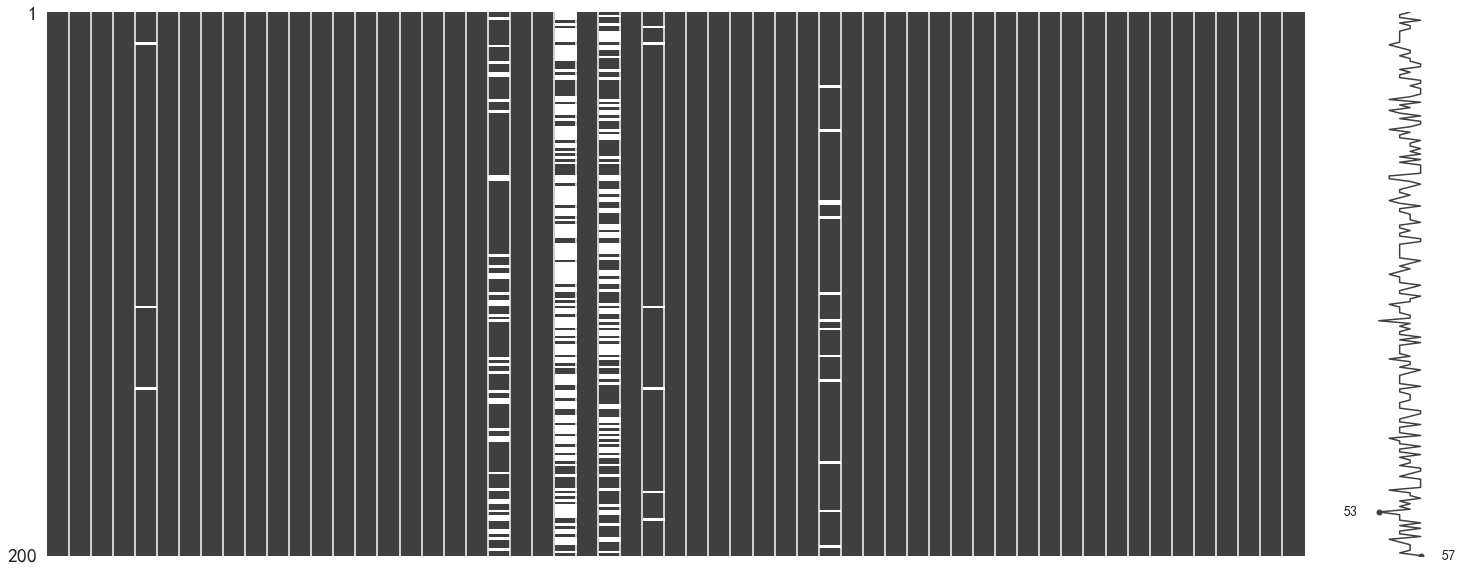

In [ ]:
msno.matrix(fullset.drop(['id','target'],axis=1).sample(200).replace(-1,np.nan)) 

# 更清晰的展示缺失值的分布，但是在这里是无效的，主要用于时间序列数据，但这个数据不是！

<AxesSubplot:>

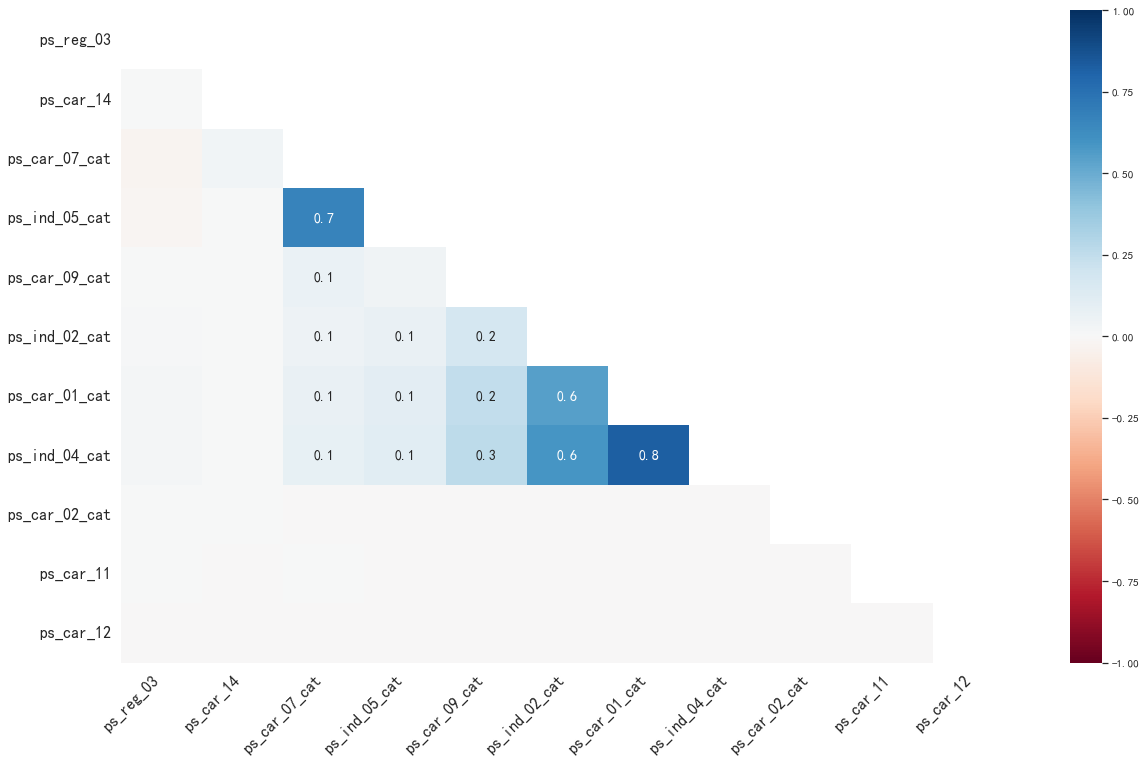

In [ ]:
msno.heatmap(fullset[cols_to_imp].replace(-1,np.nan))

<AxesSubplot:>

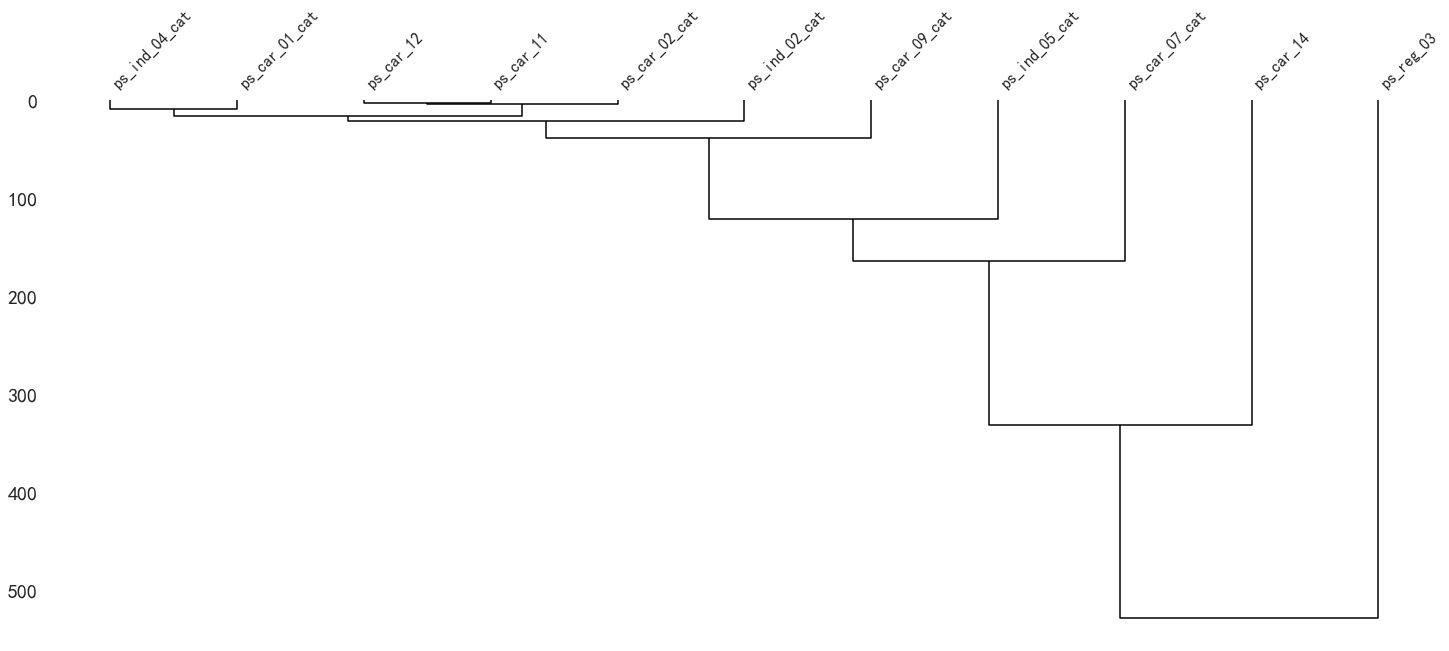

In [ ]:
msno.dendrogram(fullset[cols_to_imp].replace(-1,np.nan))

## 多变量填充

From the above figure, you can see the degree of missing value correlation between each pair of variables, such as:

The absence of ps_car_01_cat will lead to the absence of ps_ind_04_cat, which is a positive relationship and the degree of correlation is very high!

Therefore, next I will introduce to you [Multi-variable filling], If there is a correlation between variables causing missing values ​​(heatmap above)

As you can see from the picture above, we try to use the multi-variable filling method to fill in related variables!

- ps_ind_05_cat | ps_car_07_cat
- ps_car_01_cat | ps_ind_02_cat | ps_ind_04_cat
- ps_reg_03 | ps_car_14 （连续型）

The above two groups have strong missing value correlations between the groups. The last group is a continuous variable. Let’s introduce the method now:


Here we introduce the following multi-variable filling methods:

https://scikit-learn.org/stable/modules/impute.html

---

- Multivariate Imputation By Chained Equations (MICE) 
- KNN


In [ ]:
set1 = ['ps_ind_05_cat','ps_car_07_cat']
set2 = ['ps_car_01_cat','ps_ind_02_cat','ps_ind_04_cat']
set3 = ['ps_reg_03','ps_car_14']

#### MICE

MICE first calculates the mean of every column where there is a missing value and uses the mean value as a placeholder. Then it runs a series of regression models (chained equations) to impute each missing value sequentially

In [ ]:
%%time

from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10, random_state=123)

imp_mean = IterativeImputer(estimator=rf, missing_values=-1, random_state=0)
set1_imp = imp_mean.fit_transform(train[set1])

Wall time: 3.62 s


In [ ]:
%%time
set2_imp = imp_mean.fit_transform(train[set2])

Wall time: 14.9 s


Just going from 2 variables to 3 variables, the running time increases exponentially，expensive！

It can be seen that for set1, this method is not suitable for filling categorical variables. It directly fills integers into decimals. If the decimals are directly rounded, Then it is no different from direct mode filling (univariate filling).

For set2, it seems that there is no direct filling according to the mode, and the missing values ​​are filled to about 8, but the missing values ​​​​are too few. There are only a few hundred missing values ​​​​in hundreds of thousands of data, which is really not enough to see, and this kind of filling It has little impact on the original data.


In [ ]:
%%time
set3_imp = imp_mean.fit_transform(train[set3])

Wall time: 2min 19s


C:\Users\gzjgz\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



In [ ]:
pd.DataFrame(set3_imp,columns = set3)

ps_reg_03  ps_car_14
0        0.718070   0.370810
1        0.766078   0.388716
2        0.855884   0.347275
3        0.580948   0.294958
4        0.840759   0.365103
...           ...        ...
595207   0.692820   0.385487
595208   1.382027   0.378471
595209   0.659071   0.398748
595210   0.698212   0.384968
595211   0.776784   0.378021

[595212 rows x 2 columns]

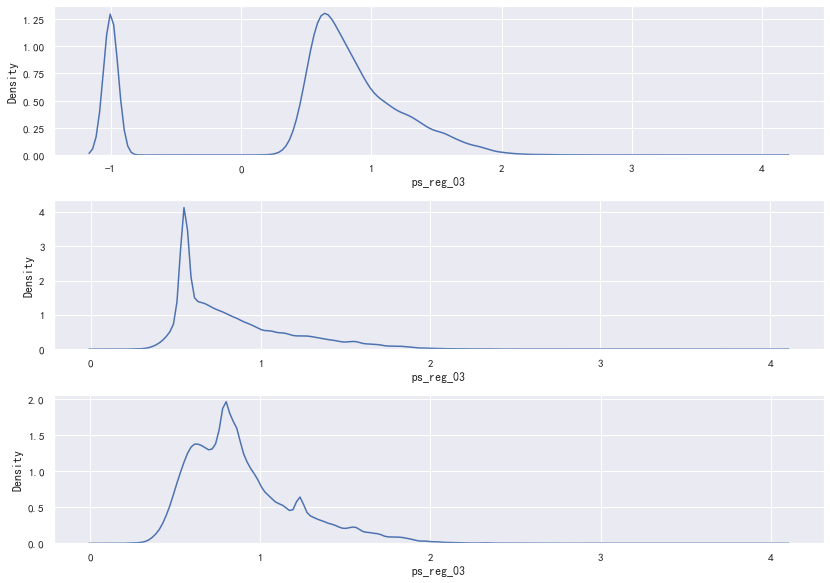

In [ ]:
plt.subplot(3,1,1)
sns.kdeplot(train[set3[0]])
plt.subplot(3,1,2)
sns.kdeplot(train[set3[0]].replace(-1,np.nan).fillna(train[set3[0]].mean()))
plt.subplot(3,1,3)
sns.kdeplot(pd.DataFrame(set3_imp,columns = set3)[set3[0]])

plt.tight_layout()

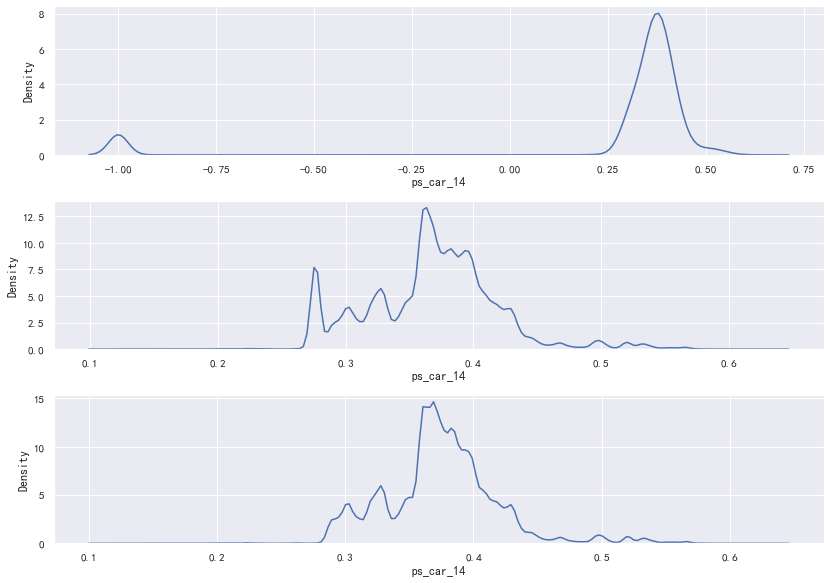

In [ ]:
plt.subplot(3,1,1)
sns.kdeplot(train[set3[1]])
plt.subplot(3,1,2)
sns.kdeplot(train[set3[1]].replace(-1,np.nan).fillna(train[set3[1]].mean()))
plt.subplot(3,1,3)
sns.kdeplot(pd.DataFrame(set3_imp,columns = set3)[set3[1]])

plt.tight_layout()

可以看出，MICE可以更好地吻合原变量的概率分布，所以我们选择使用MICE填充！

In [ ]:
train[set3] = pd.DataFrame(set3_imp,columns = set3)

#### KNN

In [ ]:
%%time
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(missing_values=-1,n_neighbors=2000)
# imputer.fit_transform(train[set1])

# Wall time: 7min 35s

Wall time: 0 ns


### Univariate Imputation

- fillna
- replace
- SimpleImputer
- Intepolate

Here we mainly use SimpleImputer！


- If "<font color=red>mean</font>", then replace missing values using the mean along each column. Can only be used with numeric data.
- If "<font color=red>median</font>", then replace missing values using the median along
  each column. Can only be used with numeric data.
- If "<font color=red>most_frequent</font>", then replace missing using the most frequent
  value along each column. Can be used with strings or numeric data.
  If there is more than one such value, only the smallest is returned.
- If "<font color=red>constant</font>", then replace missing values with fill_value. Can be
  used with strings or numeric data.

In [ ]:
from sklearn.impute import SimpleImputer 

In [ ]:
mode_imputer = SimpleImputer(missing_values = -1, strategy='most_frequent',add_indicator=True)

In [ ]:
missing_data[4:]
# These are variables that have not been filled in yet. We will fill them with mode.
# Because the last two missing values ​​are too few, they have no impact.

missing missing_percent            imputation
colname                                                     
ps_car_07_cat    28820    28820(1.94%)                  mode
ps_ind_05_cat    14519    14519(0.98%)                  mode
ps_car_09_cat     1446      1446(0.1%)                  mode
ps_ind_02_cat      523      523(0.04%)                  mode
ps_car_01_cat      267      267(0.02%)                  mode
ps_ind_04_cat      228      228(0.02%)                  mode
ps_car_02_cat       10        10(0.0%)                  mode
ps_car_11            6         6(0.0%)        (mode, median)
ps_car_12            1         1(0.0%)  (mode, median, mean)

In [ ]:
imp = mode_imputer.fit_transform(train[missing_data[4:].index])

In [ ]:
train[missing_data[4:].index]=pd.DataFrame(imp).iloc[:,:len(missing_data[4:].index)]

In [ ]:
train[missing_data[4:].index] = train[missing_data[4:].index].astype('int64')

In [ ]:
# drop columns
train.drop(cols_to_drop,axis=1,inplace=True)

In [ ]:
# check out if we still have -1 
(train == -1).sum().sum()

0

In [ ]:
train.to_csv('train_imp.csv')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=185fc705-b61f-4bb6-be30-c3c88dd0b19b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>